# GENERATOR AUDIO

Untuk generate audio format .wav, untuk keperluan training dan testing.

In [22]:
%matplotlib inline
import IPython.display as ipd
from ipywidgets import interact, interactive, fixed

import os
import audioop
import pyaudio
import wave
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import copy
from scipy.signal import butter, lfilter
import scipy.ndimage
import librosa
import librosa.display
import random
from tensorflow.python.platform import gfile
import os
import time
from array import array
import struct

#for removing future warnings
import warnings
warnings.filterwarnings('ignore')

## PARAMETERS

In [8]:
WORD_TO_TRAIN = ['ba','ta','si','mi','nu','ju']
PATH_TO_TRAIN = os.getcwd()+'/data/train'
PATH_TO_TEST = os.getcwd()+'/data/test'
FILE_PREFIX = "irza"
WORKPATH = PATH_TO_TRAIN

In [80]:
class AudioFile:
    """
    Untuk menggunakan object Audiofile gunakan
    a = a.AudioFile('namafile.wav')
    lalu gunakan
    a.play
    a.record
    dan lain2
    
    """
    chunk = 2048
    FORMAT = pyaudio.paFloat32
    CHANNELS = 1
    RATE = 16000
    length_capture = 20  #20 ms
    overlap_frame = 4    #4 ms
    start_at = 7         #maybe not used
    end_at = 100
    DEBUG = False

    def __init__(self, file):
        self.file = file

    def play(self,filename=""):
        if filename=="": filename=self.file
        self.wf = wave.open(filename, 'rb')

        # instantiate PyAudio (1)
        self.p = pyaudio.PyAudio()

        # open stream (2)
        self.stream = self.p.open(format=self.p.get_format_from_width(self.wf.getsampwidth()),
                channels=self.wf.getnchannels(),
                rate=self.wf.getframerate(),
                output=True)

        # read data
        self.data = self.wf.readframes(self.chunk)

        # play stream (3)
        while len(self.data) > 0:
            self.stream.write(self.data)
            self.data = self.wf.readframes(self.chunk)
            
            
        # stop stream (4)
        self.stream.stop_stream()
        self.stream.close()

        # close PyAudio (5)
        self.p.terminate()

    def record(self, length=3, thres=0, filename=""):
        if filename=="": filename=self.file
        """Merekam length dalam detik, thres adalah sensitivitas mic"""
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Recording")
        l = []
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            
            for i in range(0,len(data),4):
                data2 = struct.unpack('f',data[i:i+4])[0]
                l.append(data2)
            
            
            rms = audioop.rms(data,2)
            if rms >= thres:
                self.frames.append(data)
           
                
        print("finished recording")
 
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        
        self.wf = wave.open(filename, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close() 
        return l
        
    def test(self, length=5):
        """Merekam length dalam detik, thres adalah sensitivitas mic"""
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Mulai Recording\n...  Bersiap diam")
        time.sleep(2)
        print("Sekarang diam.")
        
        self.rms_sepi = []
        self.rms_bicara = []
        for i in range(0, int(self.RATE / self.chunk * (length / 2))):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            self.rms_sepi.append(rms)
        
        time.sleep(2)
        print("\nSekarang bicara sewajarnya")
        for i in range(0, int(self.RATE / self.chunk * (length / 2))):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            self.rms_bicara.append(rms)

        time.sleep(1)
        
        print("\nmax Threshold Sepi:", max(self.rms_sepi))
        print("max Threshold Bicara:", max(self.rms_bicara))
                
        print("Selesai merekam, gunakan nilai sedikit diatas Threshold sepi ")
 
        self.stream.stop_stream()
        self.stream.close()

    def plot(self,bgn,lst,filename=""):
        if filename=="": filename=self.file
        # read audio samples
        input_data = read(filename)
        audio = input_data[1]
        
        #put to normalize
        audio = audio / (2.**(16-1))  # normalize

        plt.plot(audio[bgn:lst])
        # label the axes
        plt.ylabel("Amplitude")
        plt.xlabel("Time")
        # set the title  
        plt.title("Recorded Wav")
        # display the plot
        plt.show()
        # Usage example for pyaudio

    def libplot(self, filename=""):
        if filename=="": filename=self.file
        sr, wave = read(filename)
        #wave = wave.astype('float')
        wave = wave / (2.**(16-1))  # normalize

        plt.figure(figsize=(12,4))
        librosa.display.waveplot(wave, sr=sr)

    def plotfile(self, filename="", title="" ):
        if filename=="": filename=self.file
        sr, wave = read(filename)
        plt.figure(figsize=(12,4))
        plt.title(title)
        librosa.display.waveplot(wave, sr=sr)
   
    def libspec(self, filename=""):
        if filename=="": filename=self.file
        sr, wave = read(filename)
        #wave = wave.astype('float')
        wave, sr = librosa.load(filename)
        D = librosa.stft(wave,hop_length=64)
        plt.figure(figsize=(12,4))
        librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0],ref=np.max),
            y_axis='log', x_axis='time')
        plt.title('Power spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        
    def aufile(self):
        return self.file
    
    def stagrec(self, length=3, thres=600, frame=5, t_cycle=0):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []
        self.temp_frames = []
        self.captured = []
        self.captured_frame_count = 0
        self.the_overlap=[]

        print("Recording")
        
        self.tcyc = 0
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)

            #cycle counter untuk hitung waktu jeda antar kata
            if t_cycle != 0:
                self.tcyc += 1
 
            if rms >= thres:
                
                #masukkan frame stream
                self.frames.append(data)
                self.tcyc = 0
                print(len(self.frames))
            if t_cycle != 0:
                if self.tcyc > t_cycle:
                    print(".")
                    self.tcyc = 0
                
        print("finished recording")
        #print(len(self.frames))
        #print(len(self.frames[1]))
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        self.files=[]
        for i in range(len(self.frames)):
            self.fnm=self.file
            self.fn = self.fnm.split('.wav')[0]
            if self.DEBUG: print(self.fn)
            self.fn = self.fn + str(i)+'-f.wav'
            
            self.files.append(self.fn)
            
            self.wf = wave.open(self.fn, 'wb')
            self.wf.setnchannels(self.CHANNELS)
            self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
            self.wf.setframerate(self.RATE)
            self.frm = []
            for s in range(frame):
                if (i+s)<len(self.frames):
                    self.frm.extend(self.frames[i+s])

                
            self.wf.writeframes(bytes(self.frm))
            
            #self.wf.writeframes(b''.join([self.frames[i]]))
            self.wf.close()
        return self.files

    def stream_pred(self, length=3, thres=600, frame=5):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []
        self.temp_frames = []
        self.captured = []
        self.captured_frame_count = 0
        self.the_overlap=[]

        print("Recording")
        
        self.fl=0
        self.pl=[]
        for i in range(0, int(self.RATE / self.chunk * length)):
            self.fl += 1
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            
            if rms >= thres:
                
                
                self.matrx = []
                self.frames.append(data)
                if self.fl==frame:
                    f=mfcc_dat(data,n_mfcc=25,PAD_WIDTH=44)
                    y_pred = model.predict(x=f.reshape(1,1100))
                    cls_pred = np.argmax(y_pred, axis=1)
                    self.this_pred = list(LABEL_TO_INDEX_MAP)[int(cls_pred)]
                    self.pl.append(self.this_pred)
                    print(self.this_pred)
                    self.fl=0

                
        print("finished recording")
        #print(len(self.frames))
        #print(len(self.frames[1]))
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        self.files=[]
        for i in range(len(self.frames)):
            self.fnm=self.file
            self.fn = self.fnm.split('.wav')[0]
            if self.DEBUG: print(self.fn)
            self.fn = self.fn + str(i)+'-f.wav'
            
            self.files.append(self.fn)
            
            self.wf = wave.open(self.fn, 'wb')
            self.wf.setnchannels(self.CHANNELS)
            self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
            self.wf.setframerate(self.RATE)
            self.frm = []
            for s in range(frame):
                if (i+s)<len(self.frames):
                    self.frm.extend(self.frames[i+s])

                
            self.wf.writeframes(bytes(self.frm))
            
            #self.wf.writeframes(b''.join([self.frames[i]]))
            self.wf.close()
        return self.files

    def stream_rec(self, length=3, thres=0, frame=0, overlap=0, t_cycle=0):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []
        self.captured = []
        self.the_overlap=[]

        print("Recording")

        #reset frame counter
        self.captured_frame_count = 0
        self.tcyc = 0
        self.file_count = 0
        for i in range(0, int(self.RATE / self.chunk * length)):
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)

            #cycle counter untuk hitung waktu jeda antar kata
            if t_cycle != 0:
                self.tcyc += 1
 
            if rms >= thres:
                if frame>0:
                    self.tcyc = 0
                    self.captured_frame_count += 1
                    print("cfc1:",self.captured_frame_count)
                    if(self.captured_frame_count>=frame-overlap) and (self.captured_frame_count<frame):
                        self.the_overlap.append(data)
                        print('cfc2-append:',self.captured_frame_count)
                    if(self.captured_frame_count>frame):
                        self.the_overlap.append(data)
                        self.captured.append(self.frames)
                        self.file_count += 1
                        self.seq_write(self.frames,self.file_count)
                        self.frames=self.the_overlap
                        self.the_overlap = []
                        print('purge:',self.captured_frame_count)
                        print(len(self.frames))
                        self.captured_frame_count = 0

                #masukkan frame stream
                self.frames.append(data)

            if t_cycle != 0:
                if self.tcyc > t_cycle:
                    self.file_count += 1
                    self.seq_write(self.frames,self.file_count)
                    self.frames=[]
                    self.tcyc = 0

            
        print("finished recording")
        #print(len(self.frames))
        #print(len(self.frames[1]))
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        return 

    def seq_write(self, frames, no_seq):
        self.fn = self.file.split('.wav')[0]
        if self.DEBUG: print(self.fn)
        self.fn = self.fn + str(no_seq)+'-f.wav'
        self.wf = wave.open(self.fn, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close()
        print("recorded:",self.fn)

    def mfcc(self, filename="", n_mfcc=25, duration=None, sr=22050):
        if filename=="": filename=self.file
        #wv, sr = librosa.load(filename, duration=duration)
        sr, wv = read(filename)
        #wv = wv.astype('float')
        wv = wv / (2.**(16-1))  # normalize
        plt.figure(figsize=(10,10))
        mfcc = librosa.feature.mfcc(wv, n_mfcc=n_mfcc, sr=sr)
        plt.imshow(mfcc)

    def specs(self, filename="", offset=0.0, duration=None, sr=22050):
        if filename=="": filename=self.file
        wv, sr = librosa.load(filename, offset=offset, duration=duration, sr=sr)
        #sr, wv = read(filename)
        #wv = wv.astype('float')
        D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(wv))[0])
        librosa.display.specshow(D, y_axis='log')
        plt.title("Power db - "+ str(D.shape))
        plt.colorbar()
        
    def cstft(self, filename="",n_fft=2048, duration=None):
        if filename=="": filename=self.file
        #wv, sr = librosa.load(filename, mono=True, duration=duration)
        sr, wv = read(filename)
        #wv = wv.astype('float')
        wv = wv / (2.**(16-1))  # normalize

        cstft = librosa.feature.chroma_stft(wv,n_fft=n_fft)
        plt.figure(figsize=(6,4))
        plt.title(filename + str(cstft.shape))
        librosa.display.specshow(cstft,x_axis='time')
        plt.colorbar()
        


In [81]:
a = AudioFile("myt-16000.wav")
aa = a.record(length=1)

Recording
finished recording


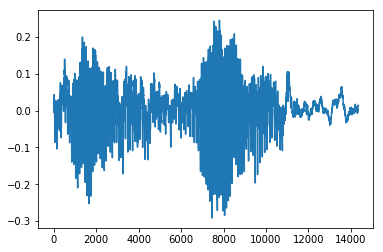

In [86]:
plt.plot(aa)

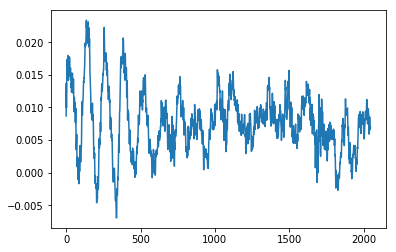

In [73]:
plt.plot(l)

In [87]:
ipd.Audio('myt-16000.wav')

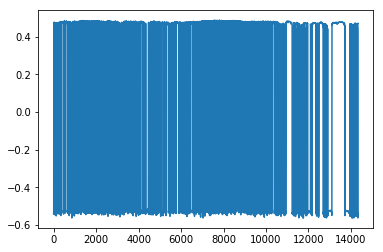

In [88]:
wv, sr = librosa.load('myt-16000.wav',sr=16000)
plt.plot(wv)

In [50]:
struct.unpack("q",cc[0:8])

(996155589433821812,)

In [ ]:
def replay():
    #to replay
    for i in WORD_TO_TRAIN:
        #gunakan PATH_TO_TEST atau PATH_TO_TRAIN
        a = AudioFile(WORKPATH+"/"+i+"/"+i+"-"+FILE_PREFIX+"-"+rann+".wav")
        a.play()
    
def playlist(thelist):
    for i in thelist:
        a = AudioFile(i)
        a.play()
        a.plot(0,-1)

In [5]:
def generate(WORKPATH=WORKPATH,style="FULLT", frame=5):
    """ 
    Gunakan generate ini untuk membuat SET dari yang ingin di training atau
    untuk SET TESTING, gunakan frame untuk menandakan panjang dari frame
    yang ingin di deteksi
    """
    files=[]
    #Generate AUDIO FILE

    #create the dir 
    for i in WORD_TO_TRAIN:
        try:
            os.mkdir(PATH_TO_TRAIN+"/"+i)
            os.mkdir(PATH_TO_TEST+"/"+i)
        except:
            pass
    
    rann = str(random.randint(0,5000))
    print("Sequence:",rann)

    #use this for shuffle the word
    random.shuffle(WORD_TO_TRAIN)

    for i in WORD_TO_TRAIN:
        #gunakan PATH_TO_TEST atau PATH_TO_TRAIN
        file = WORKPATH+"/"+i+"/"+i+"-"+FILE_PREFIX+"-"+rann+".wav"
        a = AudioFile(file)
        print("\nSilahkan baca kalau sudah recording :",i)
        a.stagrec(length=3,thres=800,frame=7)
        files.append(file)
    
    print("\nSelesai proses merekam ke:",WORKPATH)
    return files

In [6]:
def del_small_file(minsize=40000):
    for i in WORD_TO_TRAIN:
        f = WORKPATH+"/"+i
        print(f)
        lst = os.listdir(f)
        for s in lst:
            fl = str(f+'/'+s)
            sz = os.path.getsize(fl)
            if sz<minsize:
                os.remove(fl)
                print(fl,sz)  

## Bermain generator di sini.
uncomment yang anda ingin lakukan.

In [7]:
if __name__ == "__main__":
#MAU APA LO??

    #workdir = os.path.join(os.getcwd(),"data/train/ba")
    #flst= os.listdir(workdir)

    #for i in flst:
    #    a = AudioFile(os.path.join(workdir,i))
    #    print(os.path.join(workdir,i))

    a = AudioFile('mytest-16000.wav')
    a.record(3,thres=600)
    #a.play()
    #a.plot(0,-1)
    #a.specs()
    #a.libplot()
    #a.libspec()
    #a.cstft()
    #a.mfcc()
    #a.test()
    #f = a.record(0.05,500)
    #lst = a.stream_rec(length=5,thres=500, frame=0, overlap=0, t_cycle=50)
    #playlist(lst)

    
    #WORKPATH = PATH_TO_TEST
    #generate(WORKPATH)
        #a.specs(filename=os.path.join(workdir,i))

    #del_small_file()
    #a.specs('mytest.wav')

Recording
finished recording


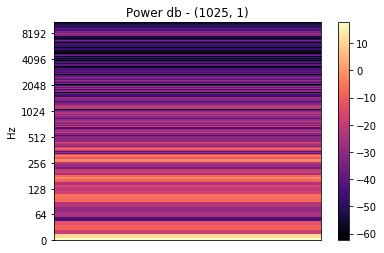

In [14]:
a.specs('mytest-16000.wav',offset=0.0, duration=0.02, sr=16000)

In [61]:
wv, sr = librosa.load('mytest-16000.wav',sr=16000)

320.0

In [8]:
ipd.Audio('mytest-16000.wav')

array([4495, 8064, 6600, ...,  358,  358,  380], dtype=int16)

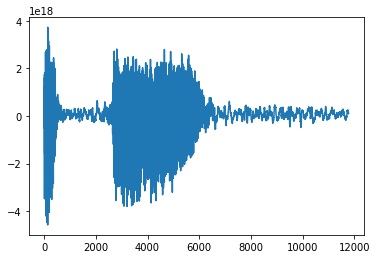

In [8]:
#f, sr = librosa.load('mytest.wav')
sr, f = read('mytest-16000.wav')
af = np.frombuffer(f, np.int64)
plt.plot(af)



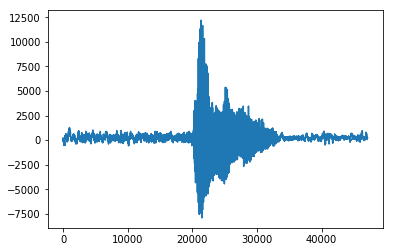

In [12]:
sig = np.frombuffer(f, dtype='<i2').reshape(-1, 1)
plt.plot(sig)

# Save menjadi Modul

Jalanin ini akan save menjadi module python generator.py

In [13]:
!jupyter nbconvert --to script generator.ipynb


[NbConvertApp] Converting notebook generator.ipynb to script
[NbConvertApp] Writing 18521 bytes to generator.py


In [17]:
sr,wv = scipy.io.wavfile.read('mytest-16000.wav')

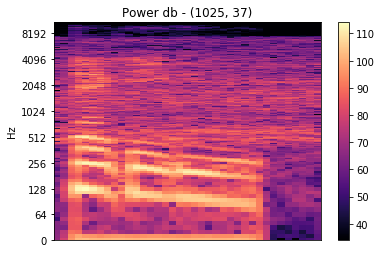

In [19]:
a.specs('outs.wav')

In [23]:
wv

array([0.01324463, 0.01348877, 0.01324463, ..., 0.01092529, 0.01028442,
       0.01004028])

In [28]:
a.play('data/noise/doing_the_dishes.wav')

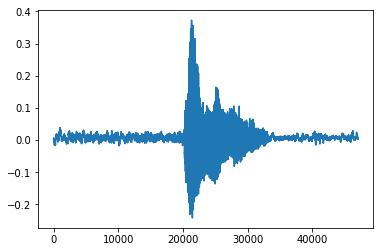

In [27]:
plt.plot(gg)

In [22]:
wv, sr = librosa.load('mytest.wav',sr=16000)
print(sr,wv)
sr, wv = read('mytest.wav')
print(sr,wv)
wv = wv / (2.**(16-1))  # normalize
print(wv)

16000 [0.01324463 0.01348877 0.01324463 ... 0.01092529 0.01028442 0.01004028]
16000 [434 442 434 ... 358 337 329]
[0.01324463 0.01348877 0.01324463 ... 0.01092529 0.01028442 0.01004028]
